In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv("flat_houses_v6.csv")

In [3]:
df.columns

Index(['PROP_ID', 'PROPERTY_TYPE', 'CITY_NAME', 'LOCALITY_NAME', 'OWNTYPE',
       'BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'FURNISH', 'LATITUDE',
       'LONGITUDE', 'PRICE_CR', 'CALCULATED_AREA_SQFT', 'AGE_POSSESSION',
       'AMENITIES_CLUSTER', 'FLOOR_CATEGORY'],
      dtype='object')

In [5]:
df.drop(columns = ["PROP_ID", "LATITUDE","LONGITUDE"], inplace = True)

In [6]:
df.columns

Index(['PROPERTY_TYPE', 'CITY_NAME', 'LOCALITY_NAME', 'OWNTYPE', 'BEDROOM_NUM',
       'BATHROOM_NUM', 'BALCONY_NUM', 'FURNISH', 'PRICE_CR',
       'CALCULATED_AREA_SQFT', 'AGE_POSSESSION', 'AMENITIES_CLUSTER',
       'FLOOR_CATEGORY'],
      dtype='object')



---



---



In [ ]:
from sklearn.preprocessing import OrdinalEncoder

#Create a copy of the original data for label encoding
data_label_encoded = df.copy()

categorical_cols = df.select_dtypes(include = ['object']).columns

#Apply label encoding to categorical columns
for col in categorical_cols:
  oe = OrdinalEncoder()
  data_label_encoded[col] = oe.fit_transform(data_label_encoded[[col]])
  print(oe.categories_)

# Splitting the dataset into training and testing datasets
X_label = data_label_encoded.drop('PRICE_CR', axis = 1)
y_label = data_label_encoded['PRICE_CR']

In [9]:
X_label.sample(5)

,PROPERTY_TYPE,CITY_NAME,LOCALITY_NAME,OWNTYPE,BEDROOM_NUM,BATHROOM_NUM,BALCONY_NUM,FURNISH,CALCULATED_AREA_SQFT,AGE_POSSESSION,AMENITIES_CLUSTER,FLOOR_CATEGORY
1039,0.0,1.0,742.0,1.0,2.0,2,3.0,2.0,1100.020371,0.0,2.0,1.0
5571,1.0,5.0,707.0,1.0,4.0,5,2.0,1.0,3600.144006,3.0,0.0,1.0
6402,1.0,5.0,906.0,1.0,6.0,4,4.0,1.0,1986.343886,3.0,0.0,2.0
1615,0.0,1.0,742.0,1.0,3.0,2,4.0,0.0,1500.000000,2.0,1.0,1.0
4911,1.0,0.0,595.0,1.0,2.0,1,0.0,1.0,800.000000,1.0,0.0,1.0


In [10]:
categorical_cols

Index(['PROPERTY_TYPE', 'CITY_NAME', 'LOCALITY_NAME', 'OWNTYPE', 'FURNISH',
       'AGE_POSSESSION', 'AMENITIES_CLUSTER', 'FLOOR_CATEGORY'],
      dtype='object')

## Technique 1:- Correlation Analysis

<Axes: >

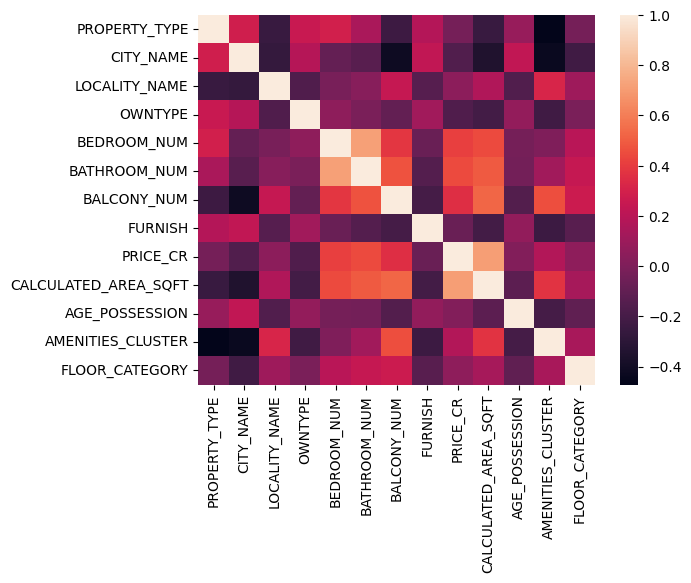

In [11]:
sns.heatmap(data_label_encoded.corr())

In [14]:
fi_df1 = data_label_encoded.corr()['PRICE_CR'].iloc[1:].to_frame().reset_index().rename(columns={'index':'feature','PRICE_CR':'corr_coeff'}).sort_values(by = "corr_coeff", ascending = False)
fi_df1

,feature,corr_coeff
7,PRICE_CR,1.000000
8,CALCULATED_AREA_SQFT,0.708083
4,BATHROOM_NUM,0.443932
3,BEDROOM_NUM,0.410234
5,BALCONY_NUM,0.353079
10,AMENITIES_CLUSTER,0.177141
11,FLOOR_CATEGORY,0.055744
1,LOCALITY_NAME,0.049393
9,AGE_POSSESSION,0.014510
6,FURNISH,-0.072173


## Technique 2:- Random Forest Feature Importance

In [15]:
from sklearn.ensemble import RandomForestRegressor
rf_label = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_label.fit(X_label, y_label)

fi_df2 = pd.DataFrame({
    'feature': X_label.columns,
    'rf_importance': rf_label.feature_importances_
}).sort_values(by = 'rf_importance', ascending = False)

fi_df2

,feature,rf_importance
8,CALCULATED_AREA_SQFT,0.608692
2,LOCALITY_NAME,0.098483
9,AGE_POSSESSION,0.058634
5,BATHROOM_NUM,0.053521
4,BEDROOM_NUM,0.041440
1,CITY_NAME,0.037951
6,BALCONY_NUM,0.024006
11,FLOOR_CATEGORY,0.023409
7,FURNISH,0.018967
0,PROPERTY_TYPE,0.015892


## Technique 3:- Gradient Boosting Feature importances

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a Random Forest regressor on label encoded data
gb_label = GradientBoostingRegressor()
gb_label.fit(X_label, y_label)

# Extract feature importance scores for label encoded data
fi_df3 = pd.DataFrame({
    'feature': X_label.columns,
    'gb_importance': gb_label.feature_importances_
}).sort_values(by='gb_importance', ascending=False)

fi_df3

,feature,gb_importance
8,CALCULATED_AREA_SQFT,0.735921
9,AGE_POSSESSION,0.072431
5,BATHROOM_NUM,0.058467
2,LOCALITY_NAME,0.050535
1,CITY_NAME,0.020681
4,BEDROOM_NUM,0.015331
11,FLOOR_CATEGORY,0.012166
10,AMENITIES_CLUSTER,0.010590
3,OWNTYPE,0.009339
0,PROPERTY_TYPE,0.007173


## Technique 4:- Permutation Importance

In [17]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X_label, y_label, test_size=0.2, random_state=42)

# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X_train_label, y_train_label)

# Calculate Permutation Importance
perm_importance = permutation_importance(rf_label, X_test_label, y_test_label, n_repeats=30, random_state=42)

# Organize results into a DataFrame
fi_df4 = pd.DataFrame({
    'feature': X_label.columns,
    'permutation_importance': perm_importance.importances_mean
}).sort_values(by='permutation_importance', ascending=False)

fi_df4

,feature,permutation_importance
8,CALCULATED_AREA_SQFT,1.160346
5,BATHROOM_NUM,0.069570
4,BEDROOM_NUM,0.053161
2,LOCALITY_NAME,0.042085
9,AGE_POSSESSION,0.038623
1,CITY_NAME,0.035520
0,PROPERTY_TYPE,0.023489
6,BALCONY_NUM,0.020472
10,AMENITIES_CLUSTER,0.011748
3,OWNTYPE,0.009203


## Technique 5 - LASSO

In [18]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_label)

# Training a LASSO Regression Model
# We'll use a relatively small value for alpha (the regularization strength) for demonstration purposes
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_scaled, y_label)

# Extract coefficients
fi_df5 = pd.DataFrame({
    'feature': X_label.columns,
    'lasso_coeff': lasso.coef_
}).sort_values(by = 'lasso_coeff', ascending = False)

fi_df5

,feature,lasso_coeff
8,CALCULATED_AREA_SQFT,1.173684
0,PROPERTY_TYPE,0.175996
5,BATHROOM_NUM,0.147004
9,AGE_POSSESSION,0.121490
7,FURNISH,0.088904
1,CITY_NAME,0.056112
4,BEDROOM_NUM,0.022878
6,BALCONY_NUM,0.000000
10,AMENITIES_CLUSTER,-0.000000
2,LOCALITY_NAME,-0.028823


## Technique 6 - RFE

In [19]:
from sklearn.feature_selection import RFE

# Initialize the base estimator
estimator = RandomForestRegressor()

# Apply RFE on the label-encoded and standardized training data
selector_label = RFE(estimator, n_features_to_select=X_label.shape[1], step=1)
selector_label = selector_label.fit(X_label, y_label)

# Get the selected features based on RFE
selected_features = X_label.columns[selector_label.support_]

# Extract the coefficients for the selected features from the underlying linear regression model
selected_coefficients = selector_label.estimator_.feature_importances_

# Organize the results into a DataFrame
fi_df6 = pd.DataFrame({
    'feature': selected_features,
    'rfe_score': selected_coefficients
}).sort_values(by='rfe_score', ascending=False)

fi_df6

,feature,rfe_score
8,CALCULATED_AREA_SQFT,0.610873
2,LOCALITY_NAME,0.102661
9,AGE_POSSESSION,0.061299
5,BATHROOM_NUM,0.050997
4,BEDROOM_NUM,0.042017
1,CITY_NAME,0.037143
6,BALCONY_NUM,0.024863
11,FLOOR_CATEGORY,0.022227
7,FURNISH,0.015113
0,PROPERTY_TYPE,0.015113


## Technique 7 - Linear Regression Weights

In [20]:
# Train a linear regression model on the label-encoded and standardized training data
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_scaled, y_label)

# Extract coefficients
fi_df7 = pd.DataFrame({
    'feature': X_label.columns,
    'reg_coeffs': lin_reg.coef_
}).sort_values(by='reg_coeffs', ascending=False)

fi_df7

,feature,reg_coeffs
8,CALCULATED_AREA_SQFT,1.186492
0,PROPERTY_TYPE,0.185762
5,BATHROOM_NUM,0.150950
9,AGE_POSSESSION,0.129001
7,FURNISH,0.098136
1,CITY_NAME,0.065355
4,BEDROOM_NUM,0.021690
6,BALCONY_NUM,0.010679
10,AMENITIES_CLUSTER,-0.004838
2,LOCALITY_NAME,-0.036114


## Technique 8 - SHAP

In [21]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 8.8 MB/s eta 0:00:00


In [ ]:
import shap

# Compute SHAP values using the trained Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_label, y_label)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


RandomForestRegressor(random_state=42)

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_label)

# Summing the absolute SHAP values across all samples to get an overall measure of feature importance
shap_sum = np.abs(shap_values).mean(axis=0)

shap_values

array([[-0.05020149,  0.01426007,  0.02159345, ...,  0.0119383 ,
        -0.01005511,  0.00266276],
       [-0.01743574,  0.07669715,  0.09142248, ..., -0.00830559,
        -0.01811335, -0.00041768],
       [-0.04401406,  0.02107682, -0.04595324, ..., -0.00182912,
        -0.0189866 ,  0.00064543],
       ...,
       [-0.05734869,  0.0059281 ,  0.07658536, ..., -0.00259015,
        -0.01285386, -0.00840617],
       [-0.03682779,  0.00607276,  0.00751702, ..., -0.00159478,
         0.03035258, -0.00616499],
       [-0.05798593,  0.03139891,  0.01836834, ..., -0.00128072,
        -0.00584453, -0.00291135]])

In [ ]:
fi_df8 = pd.DataFrame({
    'feature': X_label.columns,
    'SHAP_score': np.abs(shap_values).mean(axis=0)
}).sort_values(by='SHAP_score', ascending=False)

fi_df8

,feature,SHAP_score
8,CALCULATED_AREA_SQFT,1.046978
5,BATHROOM_NUM,0.150769
4,BEDROOM_NUM,0.132303
2,LOCALITY_NAME,0.109978
1,CITY_NAME,0.059273
9,AGE_POSSESSION,0.058073
0,PROPERTY_TYPE,0.048264
12,FLOOR,0.039676
10,AMENITIES_CLUSTER,0.035691
6,BALCONY_NUM,0.029167


In [22]:
final_fi_df = fi_df1.merge(fi_df2,on='feature').merge(fi_df3,on='feature').merge(fi_df4,on='feature').merge(fi_df5,on='feature').merge(fi_df6,on='feature').merge(fi_df7,on='feature').set_index('feature')
final_fi_df

,corr_coeff,rf_importance,gb_importance,permutation_importance,lasso_coeff,rfe_score,reg_coeffs
feature,,,,,,,
CALCULATED_AREA_SQFT,0.708083,0.608692,0.735921,1.160346,1.173684,0.610873,1.186492
BATHROOM_NUM,0.443932,0.053521,0.058467,0.069570,0.147004,0.050997,0.150950
BEDROOM_NUM,0.410234,0.041440,0.015331,0.053161,0.022878,0.042017,0.021690
BALCONY_NUM,0.353079,0.024006,0.006791,0.020472,0.000000,0.024863,0.010679
AMENITIES_CLUSTER,0.177141,0.012009,0.010590,0.011748,-0.000000,0.010748,-0.004838
FLOOR_CATEGORY,0.055744,0.023409,0.012166,0.000755,-0.053681,0.022227,-0.063361
LOCALITY_NAME,0.049393,0.098483,0.050535,0.042085,-0.028823,0.102661,-0.036114
AGE_POSSESSION,0.014510,0.058634,0.072431,0.038623,0.121490,0.061299,0.129001
FURNISH,-0.072173,0.018967,0.000576,-0.003786,0.088904,0.015113,0.098136


In [23]:
# normalize the score
final_fi_df = final_fi_df.divide(final_fi_df.sum(axis=0), axis=1)

In [24]:
final_fi_df[['rf_importance','gb_importance','permutation_importance','rfe_score']].mean(axis=1).sort_values(ascending=False)

feature
CALCULATED_AREA_SQFT    0.696773
LOCALITY_NAME           0.071120
AGE_POSSESSION          0.055410
BATHROOM_NUM            0.053361
BEDROOM_NUM             0.034297
CITY_NAME               0.030453
BALCONY_NUM             0.017679
FLOOR_CATEGORY          0.014783
AMENITIES_CLUSTER       0.010488
FURNISH                 0.008141
OWNTYPE                 0.007493
dtype: float64

In [25]:
X_label.columns

Index(['PROPERTY_TYPE', 'CITY_NAME', 'LOCALITY_NAME', 'OWNTYPE', 'BEDROOM_NUM',
       'BATHROOM_NUM', 'BALCONY_NUM', 'FURNISH', 'CALCULATED_AREA_SQFT',
       'AGE_POSSESSION', 'AMENITIES_CLUSTER', 'FLOOR_CATEGORY'],
      dtype='object')

In [30]:
# with all the cols
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor()
scores = cross_val_score(rf, X_label, y_label, cv=5, scoring='r2')

In [31]:
scores.mean()

0.6112457408816488